# Model Building and Analysis, 2004 to 2013 Data

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('hdb-price-with-features-2004to2013.csv').iloc[:, 1:]
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,mall_count_within_1km,mall_list_within_1km,school_shortest_dist,school_shortest_dist_name,good_sch_count_within_1km,good_sch_list_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured
0,2012-05-01,BISHAN,5 ROOM,450,SIN MING AVE,11 TO 15,125.0,Improved,1989,76.0,...,1,['Thomson Plaza'],0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1
1,2012-05-01,BISHAN,5 ROOM,450,SIN MING AVE,16 TO 20,120.0,Improved,1989,76.0,...,1,['Thomson Plaza'],0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1
2,2012-04-01,BISHAN,5 ROOM,450,SIN MING AVE,01 TO 05,120.0,Improved,1989,76.0,...,1,['Thomson Plaza'],0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1
3,2011-08-01,BISHAN,5 ROOM,450,SIN MING AVE,16 TO 18,125.0,Improved,1989,77.0,...,1,['Thomson Plaza'],0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1
4,2011-04-01,BISHAN,5 ROOM,450,SIN MING AVE,19 TO 21,120.0,Improved,1989,77.0,...,1,['Thomson Plaza'],0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1


In [3]:
cpi = pd.read_csv('monthly cpi.csv')
cpi = cpi.set_index('Data Series')
cpi_data = pd.DataFrame(cpi.columns, columns=['month'])
cpi_data['CPI'] = pd.to_numeric(np.array(cpi.loc['All Items']))
cpi_data = cpi_data.iloc[1: , :]
cpi_data['month'] = pd.to_datetime(cpi_data['month'])

cpi_data.head()

,month,CPI
1,2023-01-01,111.397
2,2022-12-01,111.186
3,2022-11-01,110.959
4,2022-10-01,109.893
5,2022-09-01,110.339


In [4]:
cpi_data.dtypes

month    datetime64[ns]
CPI             float64
dtype: object

In [5]:
df['month'] = pd.to_datetime(df['month'])
df = pd.merge(df, cpi_data, how = 'left')
df['adjusted_price'] = (df['resale_price'] / df['CPI']) * 100
df['year'] = pd.DatetimeIndex(df['month']).year
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,school_shortest_dist_name,good_sch_count_within_1km,good_sch_list_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,CPI,adjusted_price,year
0,2012-05-01,BISHAN,5 ROOM,450,SIN MING AVE,11 TO 15,125.0,Improved,1989,76.0,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,95.917,677669.234859,2012
1,2012-05-01,BISHAN,5 ROOM,450,SIN MING AVE,16 TO 20,120.0,Improved,1989,76.0,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,95.917,677669.234859,2012
2,2012-04-01,BISHAN,5 ROOM,450,SIN MING AVE,01 TO 05,120.0,Improved,1989,76.0,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,95.718,595499.279132,2012
3,2011-08-01,BISHAN,5 ROOM,450,SIN MING AVE,16 TO 18,125.0,Improved,1989,77.0,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,93.115,687322.128551,2011
4,2011-04-01,BISHAN,5 ROOM,450,SIN MING AVE,19 TO 21,120.0,Improved,1989,77.0,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,90.774,666490.404741,2011


In [6]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'address', 'latitude', 'longitude',
       'shortest_dist_mrt_name', 'shortest_dist_mrt', 'mrt_count_within_1km',
       'mrt_list_within_1km', 'shortest_dist_mall_name', 'shortest_dist_mall',
       'mall_count_within_1km', 'mall_list_within_1km', 'school_shortest_dist',
       'school_shortest_dist_name', 'good_sch_count_within_1km',
       'good_sch_list_within_1km', 'good_sch_score', 'good_sch_score_sap_gep',
       'distance_to_cbd_km', 'matured', 'CPI', 'adjusted_price', 'year'],
      dtype='object')

In [7]:
data = df.drop(['month','block', 'street_name', 'lease_commence_date',
                'resale_price','address', 'latitude', 'longitude',
                'shortest_dist_mrt_name', 'mrt_list_within_1km',
                'shortest_dist_mall_name','mall_list_within_1km',
                'school_shortest_dist_name', 'good_sch_list_within_1km', 'CPI'],
               axis = 1)
data.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
0,BISHAN,5 ROOM,11 TO 15,125.0,Improved,76.0,1.465274,0,0.441609,1,0.381927,1,1,1,8.14046,1,677669.234859,2012
1,BISHAN,5 ROOM,16 TO 20,120.0,Improved,76.0,1.465274,0,0.441609,1,0.381927,1,1,1,8.14046,1,677669.234859,2012
2,BISHAN,5 ROOM,01 TO 05,120.0,Improved,76.0,1.465274,0,0.441609,1,0.381927,1,1,1,8.14046,1,595499.279132,2012
3,BISHAN,5 ROOM,16 TO 18,125.0,Improved,77.0,1.465274,0,0.441609,1,0.381927,1,1,1,8.14046,1,687322.128551,2011
4,BISHAN,5 ROOM,19 TO 21,120.0,Improved,77.0,1.465274,0,0.441609,1,0.381927,1,1,1,8.14046,1,666490.404741,2011


In [8]:
# label encoding for Storey Range
# The higher the storey_range, the higher the label encoding
le = LabelEncoder()
data = data.sort_values(by='storey_range')
data['storey_range'] = le.fit_transform(data['storey_range'])
data

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
263651,BEDOK,4 ROOM,0,92.0,New Generation,73.0,0.888593,1,1.199259,0,0.232608,0,0,0,10.517164,1,365473.222560,2004
52994,SENGKANG,5 ROOM,0,122.0,Improved,88.0,0.611937,2,0.379868,2,0.204109,0,0,0,12.232941,0,443592.869999,2010
214442,JURONG WEST,5 ROOM,0,111.0,Improved,93.0,0.807287,1,0.579912,3,0.269841,0,0,0,17.834734,0,398308.360961,2008
52998,SENGKANG,5 ROOM,0,115.0,Improved,91.0,0.611937,2,0.379868,2,0.204109,0,0,0,12.232941,0,323487.695026,2007
135185,GEYLANG,3 ROOM,0,66.0,Improved,72.0,0.580310,1,1.565416,0,0.152950,1,2,1,7.046789,1,269386.410691,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96388,QUEENSTOWN,3 ROOM,21,60.0,Model A,94.0,0.163310,1,1.077468,0,0.216682,0,0,0,6.062713,1,581628.559968,2013
84597,TOA PAYOH,4 ROOM,21,91.0,Model A,94.0,0.255665,2,1.016060,0,0.377535,1,1,0,5.152027,1,724454.738044,2011
51233,QUEENSTOWN,4 ROOM,21,90.0,Model A,97.0,0.236613,1,1.146641,0,0.142235,0,0,0,5.996707,1,726527.997071,2010
152967,QUEENSTOWN,4 ROOM,21,90.0,Model A,95.0,0.207722,1,0.590811,2,0.199847,0,0,0,4.938780,1,758878.765340,2010


In [9]:
data['flat_type'].value_counts()

4 ROOM              99883
3 ROOM              78120
5 ROOM              62309
EXECUTIVE           20331
2 ROOM               2722
1 ROOM                173
MULTI-GENERATION      114
Name: flat_type, dtype: int64

In [10]:
# remove flat_types with less than 1000 instances
flat_types_counts = data['flat_type'].value_counts()
data = data[~data['flat_type'].isin(flat_types_counts[flat_types_counts < 1000].index)]
data['flat_type'].value_counts()

4 ROOM       99883
3 ROOM       78120
5 ROOM       62309
EXECUTIVE    20331
2 ROOM        2722
Name: flat_type, dtype: int64

 1 Room and Multi-Generation flats are removed.

In [11]:
# label encoding for Flat Type
data = data.sort_values(by='flat_type')
data


,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
9351,TOA PAYOH,2 ROOM,0,54.0,Improved,56.0,0.660875,2,1.563870,0,0.361258,1,1,1,5.363428,1,274269.975024,2010
262672,QUEENSTOWN,2 ROOM,2,46.0,Standard,69.0,0.460993,1,1.232966,0,0.358358,0,0,0,6.197408,1,272432.825128,2013
217038,TOA PAYOH,2 ROOM,5,43.0,Standard,61.0,0.527453,2,1.427451,0,0.360833,1,1,1,5.465003,1,148369.866725,2005
143137,BUKIT MERAH,2 ROOM,0,45.0,Improved,65.0,1.506775,0,1.883067,0,0.496541,0,0,0,5.028828,1,270310.857486,2010
18693,GEYLANG,2 ROOM,4,46.0,Standard,66.0,1.466102,0,1.749008,0,0.609750,2,2,0,6.028074,1,142729.242627,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246392,YISHUN,EXECUTIVE,2,142.0,Apartment,75.0,0.351151,1,0.964513,1,0.421954,0,0,0,14.814705,0,622885.678999,2011
163195,ANG MO KIO,EXECUTIVE,4,147.0,Apartment,85.0,0.762551,1,0.999017,1,0.429897,1,2,1,10.051317,1,722959.615928,2010
102890,SENGKANG,EXECUTIVE,8,134.0,Premium Apartment,92.0,0.676140,1,0.512788,1,0.323965,1,1,0,13.011939,0,533937.288772,2008
251603,HOUGANG,EXECUTIVE,5,149.0,Maisonette,79.0,0.420777,2,0.284256,2,0.457917,3,4,1,10.673973,0,586881.740424,2010


In [12]:
data['flat_type'] = le.fit_transform(data['flat_type'])
data

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
9351,TOA PAYOH,0,0,54.0,Improved,56.0,0.660875,2,1.563870,0,0.361258,1,1,1,5.363428,1,274269.975024,2010
262672,QUEENSTOWN,0,2,46.0,Standard,69.0,0.460993,1,1.232966,0,0.358358,0,0,0,6.197408,1,272432.825128,2013
217038,TOA PAYOH,0,5,43.0,Standard,61.0,0.527453,2,1.427451,0,0.360833,1,1,1,5.465003,1,148369.866725,2005
143137,BUKIT MERAH,0,0,45.0,Improved,65.0,1.506775,0,1.883067,0,0.496541,0,0,0,5.028828,1,270310.857486,2010
18693,GEYLANG,0,4,46.0,Standard,66.0,1.466102,0,1.749008,0,0.609750,2,2,0,6.028074,1,142729.242627,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246392,YISHUN,4,2,142.0,Apartment,75.0,0.351151,1,0.964513,1,0.421954,0,0,0,14.814705,0,622885.678999,2011
163195,ANG MO KIO,4,4,147.0,Apartment,85.0,0.762551,1,0.999017,1,0.429897,1,2,1,10.051317,1,722959.615928,2010
102890,SENGKANG,4,8,134.0,Premium Apartment,92.0,0.676140,1,0.512788,1,0.323965,1,1,0,13.011939,0,533937.288772,2008
251603,HOUGANG,4,5,149.0,Maisonette,79.0,0.420777,2,0.284256,2,0.457917,3,4,1,10.673973,0,586881.740424,2010


In [13]:
data['flat_model'].value_counts()

Improved               72385
Model A                72023
New Generation         47905
Premium Apartment      19123
Simplified             14914
Standard               12069
Apartment              11028
Maisonette              7215
Model A2                5350
Adjoined flat            560
Model A-Maisonette       478
Terrace                  235
Improved-Maisonette       36
Premium Maisonette        33
2-room                    11
Name: flat_model, dtype: int64

In [14]:
# Re-categorize flat models into broader categories
replace_values = {'Model A-Maisonette':'Maisonette', 'Improved-Maisonette':'Maisonette',
                 'Premium Maisonette':'Maisonette',}
data = data.replace({'flat_model': replace_values})
data['flat_model'].value_counts()

Improved             72385
Model A              72023
New Generation       47905
Premium Apartment    19123
Simplified           14914
Standard             12069
Apartment            11028
Maisonette            7762
Model A2              5350
Adjoined flat          560
Terrace                235
2-room                  11
Name: flat_model, dtype: int64

In [15]:
# remove flat models with less than 1000 instances
flat_model_counts = data['flat_model'].value_counts()
data = data[~data['flat_model'].isin(flat_model_counts[flat_model_counts < 1000].index)]
data['flat_model'].value_counts()

Improved             72385
Model A              72023
New Generation       47905
Premium Apartment    19123
Simplified           14914
Standard             12069
Apartment            11028
Maisonette            7762
Model A2              5350
Name: flat_model, dtype: int64

In [16]:
data['town'].sort_values().unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

In [17]:
data['flat_model'].sort_values().unique()

array(['Apartment', 'Improved', 'Maisonette', 'Model A', 'Model A2',
       'New Generation', 'Premium Apartment', 'Simplified', 'Standard'],
      dtype=object)

In [18]:
data = pd.get_dummies(data, columns = ['town','flat_model'],drop_first = True)
data.sort_index(inplace = True)
data.columns

Index(['flat_type', 'storey_range', 'floor_area_sqm', 'remaining_lease',
       'shortest_dist_mrt', 'mrt_count_within_1km', 'shortest_dist_mall',
       'mall_count_within_1km', 'school_shortest_dist',
       'good_sch_count_within_1km', 'good_sch_score', 'good_sch_score_sap_gep',
       'distance_to_cbd_km', 'matured', 'adjusted_price', 'year', 'town_BEDOK',
       'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'flat_model_Improved', 'flat_model_Maisonette', 'flat_model_Model A',
       'flat_model_Model A2', 'flat_model_New Generation',
   

In order to account for multicollinearity, we drop one of the dummy variables.

For the town dummies, Ang Mo Kio is dropped. For the flat_model dummies, Apartment is dropped.

### Check for Multicolinearity and VIF

In [19]:
data.dtypes

flat_type                         int32
storey_range                      int32
floor_area_sqm                  float64
remaining_lease                 float64
shortest_dist_mrt               float64
mrt_count_within_1km              int64
shortest_dist_mall              float64
mall_count_within_1km             int64
school_shortest_dist            float64
good_sch_count_within_1km         int64
good_sch_score                    int64
good_sch_score_sap_gep            int64
distance_to_cbd_km              float64
matured                           int64
adjusted_price                  float64
year                              int64
town_BEDOK                        uint8
town_BISHAN                       uint8
town_BUKIT BATOK                  uint8
town_BUKIT MERAH                  uint8
town_BUKIT PANJANG                uint8
town_BUKIT TIMAH                  uint8
town_CENTRAL AREA                 uint8
town_CHOA CHU KANG                uint8
town_CLEMENTI                     uint8


In [20]:
data['flat_type'] = data['flat_type'].astype("int64")
data['storey_range'] = data['storey_range'].astype("int64")

C:\Users\tammy\AppData\Local\Temp\ipykernel_27180\1764189709.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


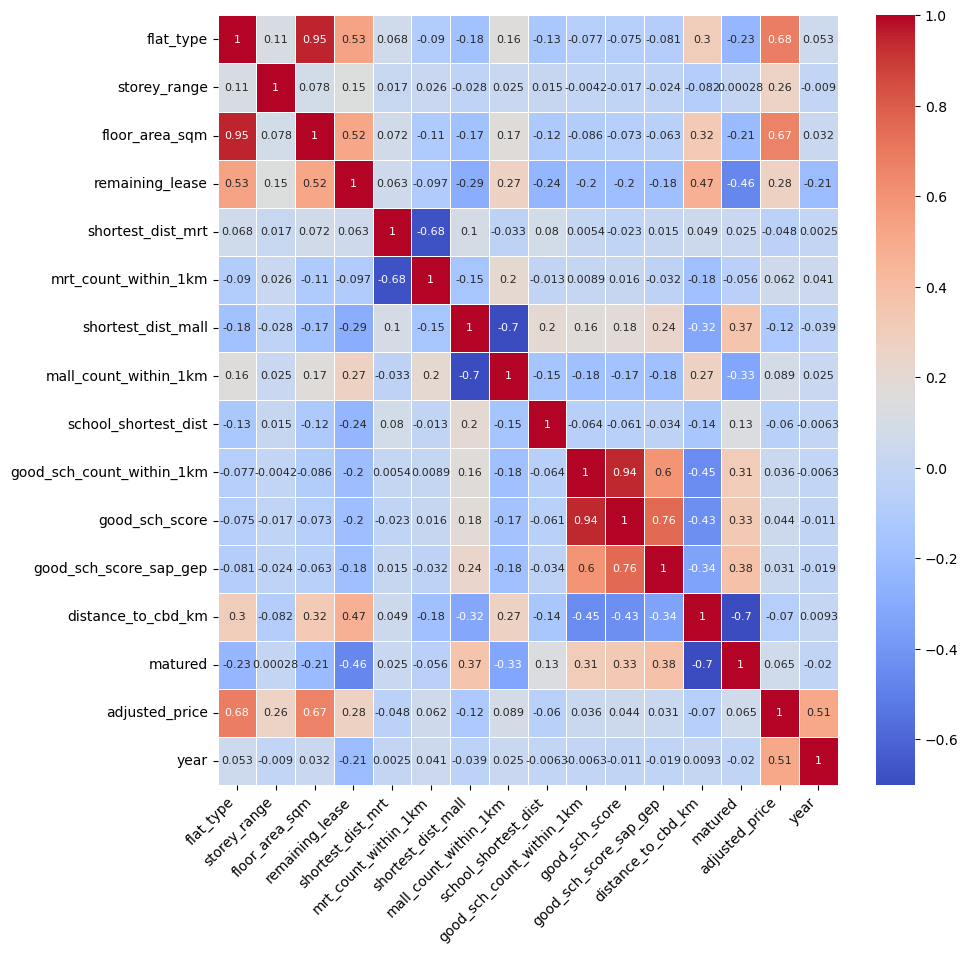

In [21]:
import seaborn as sns
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(data.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g', 
      cmap = 'coolwarm', linewidth=0.5, annot_kws={"size": 8})

plt.xticks(rotation=45, ha='right')
fig.show()


High correlation (>0.6) between:

- flat_type and floor_area_sqm (0.95)
- shortest_dist_mrt and mrt_count_within_1km (-0.68)
- mall_count_within_1km and shortest_dist_mall (-0.7)
- good_sch_count_within_1km and good_sch_score (0.94)
- good_sch_score_sap_gep and good_sch_count_within_1km (0.6)
- good_sch_score_sap_ge and good_sch_score (0.76)
- distance_to_cbd_km and matured (-0.7)



If the largest VIF is greater than 10 then there is cause for concern (Bowerman & O’Connell, 1990; Myers, 1990)

If the average VIF is substantially greater than 1 then the regression may be biased (Bowerman & O’Connell, 1990).

Tolerance below 0.1 indicates a serious problem.

Tolerance below 0.2 indicates a potential problem (Menard, 1995).

In [22]:
# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()

    return(vif)

vif_df = calc_vif(data.drop('adjusted_price',axis=1).select_dtypes(include=['int64','float64']))
vif_df

,variables,VIF,tolerance,meanVIF
0,flat_type,67.695453,0.014772,44.611966
1,storey_range,2.822651,0.354277,44.611966
2,floor_area_sqm,179.840993,0.005560,44.611966
3,remaining_lease,122.454399,0.008166,44.611966
4,shortest_dist_mrt,7.429593,0.134597,44.611966
5,mrt_count_within_1km,5.149646,0.194188,44.611966
6,shortest_dist_mall,8.010624,0.124834,44.611966
7,mall_count_within_1km,4.332943,0.230790,44.611966
8,school_shortest_dist,4.172645,0.239656,44.611966
9,good_sch_count_within_1km,17.763990,0.056294,44.611966


- flat_type and floor_area_sqm (0.95)
- shortest_dist_mrt and mrt_count_within_1km (-0.68)
- mall_count_within_1km and shortest_dist_mall (-0.7)
- good_sch_count_within_1km and good_sch_score (0.94)
- good_sch_score_sap_gep and good_sch_count_within_1km (0.6)
- good_sch_score_sap_ge and good_sch_score (0.76)
- distance_to_cbd_km and matured (-0.7)

between flat_type and floor_area_sqm, we will drop flat_type as floor_area_sqm could have more potential for feature explanation as it is a continuous variable, while flat_type has been label encoded.

For the mrt, mall, sch features, we will choose to drop the features that measure the count within 1km first, for reasons being the shortest distance features being continuous.

Between distance to cbd and matured features, we will drop matured as distance to cbd is a continous variable as well.

Between good_sch_score_sap_gep and good_sch_score, we will just drop good_sch_score_sap_gep for the time being. Depending on the results of the good_sch_score feature results, we will decide if there is reason to run the models again but with good_sch_score_sap_gep instead.

year variable is dropped as well, as we have already accounted for resale price inflation using CPI values. This should account for majority of the impact that year has on resale prices, due to the fact that generally why prices increases over time is due to inflation. It is also dropped for model simplicity.


In [23]:
dropped_features = ['mrt_count_within_1km','mall_count_within_1km',
                    'matured','good_sch_count_within_1km','flat_type','good_sch_score_sap_gep',
                    'year']

calc_vif(data.drop(dropped_features,axis=1).
         drop('adjusted_price', axis = 1).
         select_dtypes(include=['int64','float64']))

,variables,VIF,tolerance,meanVIF
0,storey_range,2.792629,0.358086,11.599831
1,floor_area_sqm,21.929531,0.045601,11.599831
2,remaining_lease,41.516238,0.024087,11.599831
3,shortest_dist_mrt,3.754818,0.266324,11.599831
4,shortest_dist_mall,3.936052,0.254062,11.599831
5,school_shortest_dist,3.651229,0.273880,11.599831
6,good_sch_score,1.661422,0.601894,11.599831
7,distance_to_cbd_km,13.556728,0.073764,11.599831


We observe that remaining_lease and floor_area_sqm still has a very high VIF score, but we shall still keep these features as we feel they are important explainators of hdb resale price.

### Performance Measure

In [24]:
def model_performance(model, X_train, X_test, y_train, y_test):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print('R^2 score =', r2)
    print('MAE:', mae)
    print('RMSE', rmse)
    
    
    return(r2, mae, rmse)
    

### Train Test Split

In [25]:
df_1 = data.drop(columns = dropped_features)

# Split target variable from dataset
y= df_1['adjusted_price']
X = df_1.drop(columns='adjusted_price')


In [26]:
X

,storey_range,floor_area_sqm,remaining_lease,shortest_dist_mrt,shortest_dist_mall,school_shortest_dist,good_sch_score,distance_to_cbd_km,town_BEDOK,town_BISHAN,...,town_WOODLANDS,town_YISHUN,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard
0,6,125.0,76.0,1.465274,0.441609,0.381927,1,8.140460,0,1,...,0,0,1,0,0,0,0,0,0,0
1,9,120.0,76.0,1.465274,0.441609,0.381927,1,8.140460,0,1,...,0,0,1,0,0,0,0,0,0,0
2,1,120.0,76.0,1.465274,0.441609,0.381927,1,8.140460,0,1,...,0,0,1,0,0,0,0,0,0,0
3,8,125.0,77.0,1.465274,0.441609,0.381927,1,8.140460,0,1,...,0,0,1,0,0,0,0,0,0,0
4,10,120.0,77.0,1.465274,0.441609,0.381927,1,8.140460,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263647,0,82.0,73.0,0.888593,1.199259,0.232608,0,10.517164,1,0,...,0,0,0,0,0,0,1,0,0,0
263648,7,67.0,73.0,0.888593,1.199259,0.232608,0,10.517164,1,0,...,0,0,0,0,0,0,1,0,0,0
263649,4,92.0,73.0,0.888593,1.199259,0.232608,0,10.517164,1,0,...,0,0,0,0,0,0,1,0,0,0
263650,7,67.0,73.0,0.888593,1.199259,0.232608,0,10.517164,1,0,...,0,0,0,0,0,0,1,0,0,0


In [27]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

In [28]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

210047 52512
210047 52512


### Feature Scaling

In [29]:
# Scale dataset
continuous_features = ['floor_area_sqm', 'remaining_lease','shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist', 'distance_to_cbd_km']

scaler = StandardScaler()
X_train_continuous = X_train[continuous_features]
X_train_continuous = scaler.fit_transform(X_train_continuous)

X_test_continuous = X_test[continuous_features]
X_test_continuous = scaler.transform(X_test_continuous)

# Replace original continuous features with scaled ones in X

X_train[continuous_features] = X_train_continuous
X_test[continuous_features] = X_test_continuous

In [30]:
X_train

,storey_range,floor_area_sqm,remaining_lease,shortest_dist_mrt,shortest_dist_mall,school_shortest_dist,good_sch_score,distance_to_cbd_km,town_BEDOK,town_BISHAN,...,town_WOODLANDS,town_YISHUN,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard
29546,7,0.133918,1.349262,0.172845,0.584246,-0.965113,0,0.033276,0,0,...,0,0,0,0,1,0,0,0,0,0
118815,5,-0.184415,-0.885629,0.873958,1.766850,0.635739,0,-1.686212,0,0,...,0,0,0,0,0,0,1,0,0,0
23556,8,1.805167,1.146090,-0.536636,-0.676437,0.765147,0,0.254538,0,0,...,0,0,0,0,0,0,0,0,0,0
69866,4,-0.900665,-0.784043,-0.884923,-0.049706,-0.946579,0,0.903686,0,0,...,0,0,0,0,1,0,0,0,0,0
118336,4,0.492043,1.044504,-1.076196,-0.961826,-0.668704,1,1.033259,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213720,4,2.242875,-0.377699,-0.899873,-1.225374,-0.770490,4,-0.326582,0,0,...,0,0,0,1,0,0,0,0,0,0
66001,2,-1.258789,-1.190387,1.826368,-0.541166,-0.126774,2,-1.197792,0,0,...,0,0,1,0,0,0,0,0,0,0
254736,4,1.327667,0.942918,0.724003,-0.573986,-0.135834,1,0.107833,0,0,...,0,0,0,0,0,0,0,0,0,0
211562,5,-0.900665,0.231817,-0.863429,0.901151,-0.713383,0,0.498403,0,0,...,0,1,0,0,1,0,0,0,0,0


In [31]:
X_test

,storey_range,floor_area_sqm,remaining_lease,shortest_dist_mrt,shortest_dist_mall,school_shortest_dist,good_sch_score,distance_to_cbd_km,town_BEDOK,town_BISHAN,...,town_WOODLANDS,town_YISHUN,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard
101257,2,-1.457748,-0.072941,1.801966,0.005517,0.590339,1,-0.604421,0,0,...,0,0,1,0,0,0,0,0,0,0
216365,4,1.248084,1.247676,3.624237,-0.303303,0.889535,0,0.487417,0,0,...,0,0,0,0,0,0,0,1,0,0
46715,5,-1.179206,-0.174527,-0.907567,-0.450300,-1.038920,0,0.889824,0,0,...,0,1,0,0,0,0,1,0,0,0
190133,5,0.173710,0.739746,0.988228,-0.051270,-0.997721,1,-0.338574,0,0,...,0,0,0,0,1,0,0,0,0,0
180947,5,-2.492330,-1.698317,-0.562391,-0.392107,1.731989,0,-2.207408,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109317,7,-0.224207,1.044504,-0.938557,-0.665673,0.034253,0,1.177143,0,0,...,0,0,0,0,1,0,0,0,0,0
15148,0,-0.940456,-1.190387,-0.327294,0.018691,0.149486,2,-0.559420,0,0,...,0,0,0,0,0,0,1,0,0,0
258353,0,-0.542540,-0.580871,-0.279367,0.076145,-0.578875,0,1.230682,0,0,...,1,0,0,0,0,0,0,0,1,0
66140,4,2.123500,-0.479285,-0.157977,0.890623,1.862819,2,-1.680684,0,0,...,0,0,0,1,0,0,0,0,0,0


## Model Building

We have shortlisted the following models to understand the drivers of HDB resale prices:
1. Linear Regression
2. Random Forest (bootstrap method)
3. XGBoost (boosting method)

Linear regression is shortlisted as it provides a useful way to interpret the respective impacts that each feature has on the hdb resale price. We will be able to infer directionality of the impacts as well.

We want to also compare the performances of ensemble methods, which are non-parametric in nature. Specifically, we shortlisted one bagging (bootstrap aggregating) method, which will be Random Forest, and one boosting method, which will be XGBoost. From this, we will compare the performances between the models and investigate feature importance.

#### 1. Linear Regression

In [32]:
lr = LinearRegression()
lin_reg_r2, lin_reg_mae, lin_reg_rmse = model_performance(lr, X_train, X_test, y_train, y_test)

R^2 score = 0.6207462998550657
MAE: 63823.77778625861
RMSE 78184.65070783856


Let's plot the coefficients and observe their respective impacts on hdb resale price

In [33]:
lr_importance = pd.DataFrame(list(zip(X_train.columns, lr.coef_)), columns =['Features', 'Coeff'])
lr_importance.sort_values(by = 'Coeff', ascending = False)

,Features,Coeff
22,town_MARINE PARADE,143412.920980
13,town_BUKIT TIMAH,143130.884185
1,floor_area_sqm,99703.070373
11,town_BUKIT MERAH,72897.684154
24,town_PUNGGOL,56370.746973
9,town_BISHAN,45229.946281
25,town_QUEENSTOWN,42449.536074
38,flat_model_Premium Apartment,37888.915705
16,town_CLEMENTI,33867.838950
30,town_TOA PAYOH,27398.658209


Let's also plot the OLS regression results, to look at the significance of the features.

In [34]:
X_constant = sm.add_constant(X_train)
lr_ols = sm.OLS(y_train,X_constant).fit()
print(lr_ols.summary())

                            OLS Regression Results                            
Dep. Variable:         adjusted_price   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     8508.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:57:34   Log-Likelihood:            -2.6658e+06
No. Observations:              210047   AIC:                         5.332e+06
Df Residuals:                  210005   BIC:                         5.332e+06
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [35]:
lr_importance['feature_importance'] = np.abs(lr_importance['Coeff'])
lr_importance = lr_importance.sort_values('feature_importance').reset_index(drop= True)
lr_importance['color'] = lr_importance['Coeff'].apply(lambda x: '#66ff8c' if x>0 else '#ff8c66')
lr_importance

,Features,Coeff,feature_importance,color
0,school_shortest_dist,1085.353392,1085.353392,#66ff8c
1,town_BUKIT PANJANG,-1389.002281,1389.002281,#ff8c66
2,town_SERANGOON,-1480.573474,1480.573474,#ff8c66
3,flat_model_Model A,1652.303530,1652.303530,#66ff8c
4,flat_model_Simplified,2129.709328,2129.709328,#66ff8c
5,good_sch_score,-5431.328836,5431.328836,#ff8c66
6,town_SENGKANG,-6787.223976,6787.223976,#ff8c66
7,storey_range,7707.804257,7707.804257,#66ff8c
8,distance_to_cbd_km,-9610.119179,9610.119179,#ff8c66
9,shortest_dist_mall,-9776.934971,9776.934971,#ff8c66


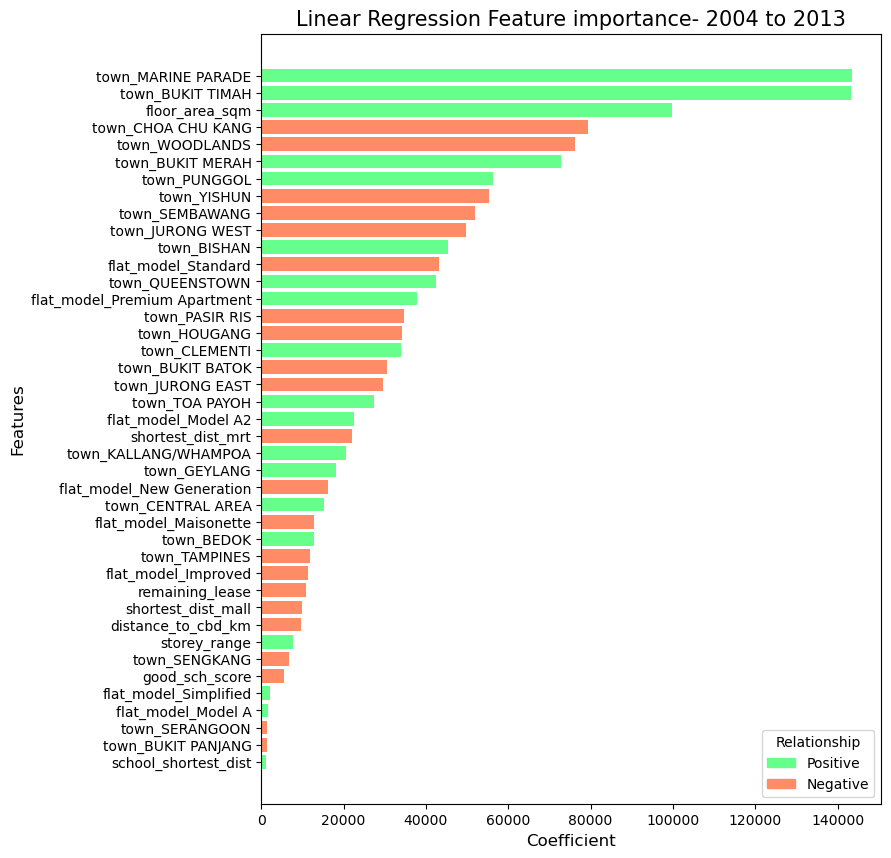

<Figure size 640x480 with 0 Axes>

In [88]:
plt.figure(figsize=(8,10))
plt.barh(lr_importance['Features'], lr_importance['feature_importance'],
         color=lr_importance['color'])


colors = {'Positive':'#66ff8c', 'Negative':'#ff8c66'}       
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, title='Relationship',loc='lower right', fontsize ='10')

plt.title('Linear Regression Feature importance- 2004 to 2013', size = 15)
plt.ylabel('Features', size = 12)
plt.xlabel('Coefficient', size = 12)

plt.show()

#### 2. Random Forest 

Computing the baseline model

In [37]:
rf = RandomForestRegressor()
rf_r2, rf_mae, rf_rmse = model_performance(rf, X_train, X_test, y_train, y_test)

R^2 score = 0.9537662910808297
MAE: 19725.00658589549
RMSE 27298.322123036305


In [58]:
rf_importance = pd.DataFrame(list(zip(rf.feature_names_in_, rf.feature_importances_)), columns =['Features', 'Coeff'])
rf_importance = rf_importance.sort_values(by = 'Coeff', ascending = True).reset_index(drop =True)
rf_importance

,Features,Coeff
0,town_CENTRAL AREA,0.000351
1,flat_model_Model A2,0.000565
2,town_PUNGGOL,0.000666
3,flat_model_Maisonette,0.000689
4,town_KALLANG/WHAMPOA,0.000746
5,town_SEMBAWANG,0.000747
6,town_CHOA CHU KANG,0.000759
7,town_TOA PAYOH,0.001008
8,town_BUKIT MERAH,0.001093
9,town_BUKIT TIMAH,0.001102


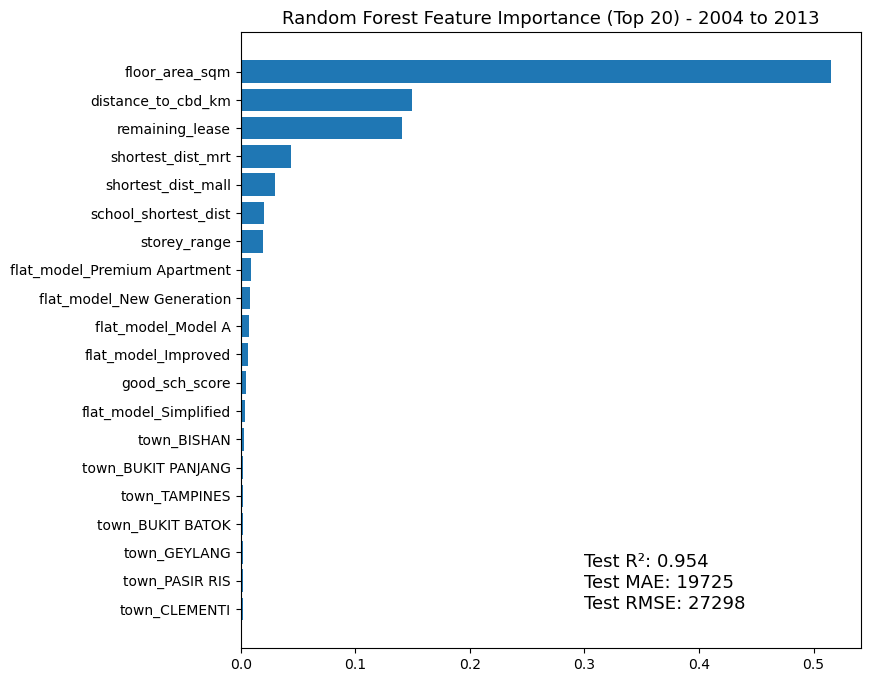

<Figure size 640x480 with 0 Axes>

In [91]:
plt.figure(figsize=(8,8))
rf_importance_graph = rf_importance.tail(20)
plt.barh(rf_importance_graph['Features'], rf_importance_graph['Coeff'])
plt.title('Random Forest Feature Importance (Top 20) - 2004 to 2013', size = 13)
plt.annotate(('Test R\u00b2: ' + str(round(rf_r2,3)) + '\nTest MAE: ' + str(round(rf_mae))+
             '\nTest RMSE: ' + str(round(rf_rmse))),
             xy=(0.3,0), fontsize = 13)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

#### Hyperparameter tuning using RandomizedSearchCV

In [39]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [40]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf1 = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf1, param_distributions = random_grid, n_iter = 2, cv = 3, verbose=2, random_state=100)
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 5.1min
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 4.7min
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 4.9min
[CV] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=30.8min
[CV] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=31.0min
[CV] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=31.9min
{'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 110}


In [41]:
y_pred = rf_random.predict(X_test)

rf_random_r2 = r2_score(y_test, y_pred)
rf_random_mae = mean_absolute_error(y_test, y_pred)
rf_random_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('R^2 score =', rf_random_r2)
print('MAE:', rf_random_mae)
print('RMSE', rf_random_rmse)
    

R^2 score = 0.9521830282466658
MAE: 19978.125168948263
RMSE 27761.80001254006


In [57]:
rf_random_importance = pd.DataFrame(list(zip(rf_random.feature_names_in_, rf_random.best_estimator_.feature_importances_)),
                                    columns =['Features', 'Coeff'])
rf_random_importance = rf_random_importance.sort_values(by = 'Coeff', ascending = True).reset_index(drop =True)
rf_random_importance

,Features,Coeff
0,town_CENTRAL AREA,0.000351
1,flat_model_Model A2,0.000484
2,flat_model_Maisonette,0.000638
3,town_KALLANG/WHAMPOA,0.000726
4,town_PUNGGOL,0.000729
5,town_CHOA CHU KANG,0.000755
6,town_SEMBAWANG,0.000773
7,town_TOA PAYOH,0.000953
8,town_BUKIT MERAH,0.001051
9,town_BUKIT TIMAH,0.001113


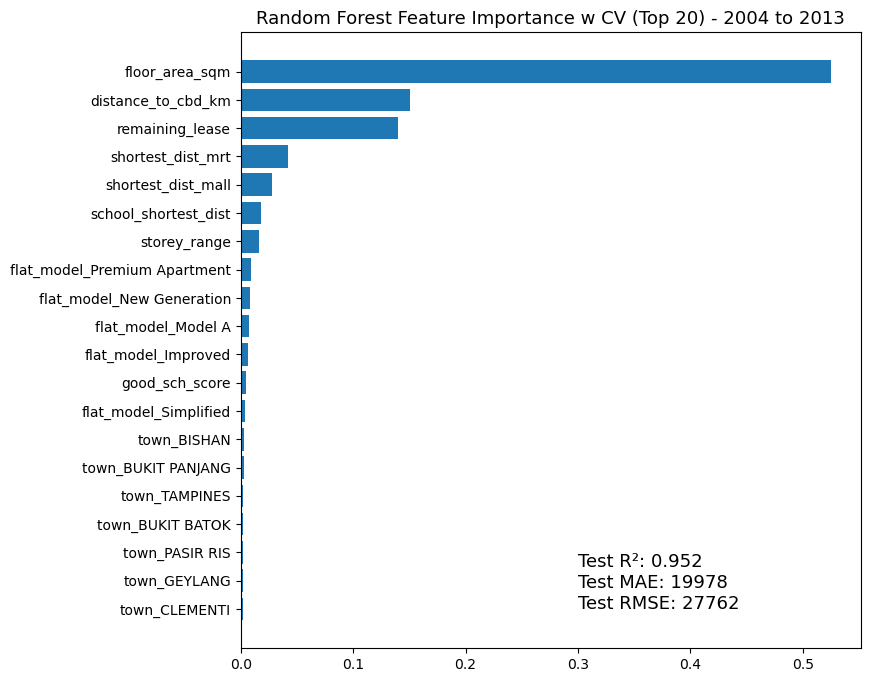

<Figure size 640x480 with 0 Axes>

In [90]:
plt.figure(figsize=(8,8))
rf_random_importance_graph = rf_random_importance.tail(20)
plt.barh(rf_random_importance_graph['Features'], rf_random_importance_graph['Coeff'])
plt.title('Random Forest Feature Importance w CV (Top 20) - 2004 to 2013', size = 13)
plt.annotate(('Test R\u00b2: ' + str(round(rf_random_r2,3)) + '\nTest MAE: ' + str(round(rf_random_mae))+
             '\nTest RMSE: ' + str(round(rf_random_rmse))),
             xy=(0.3,0), fontsize = 13)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


plt.show()

#### Out-of-Bag

In [43]:
oob_model = RandomForestRegressor(oob_score=True)
oob_r2, oob_mae, oob_rmse = model_performance(oob_model, X_train, X_test, y_train, y_test)

R^2 score = 0.9537125786763597
MAE: 19759.50332607732
RMSE 27314.174549124396


In [44]:
oob_model.oob_score_

0.9540135023058306

In [45]:
oob_importance = pd.DataFrame(list(zip(oob_model.feature_names_in_, oob_model.feature_importances_)), columns =['Features', 'Coeff'])
oob_importance = oob_importance.sort_values(by = 'Coeff', ascending = True)
oob_importance

,Features,Coeff
14,town_CENTRAL AREA,0.000385
36,flat_model_Model A2,0.000466
34,flat_model_Maisonette,0.000735
15,town_CHOA CHU KANG,0.000757
24,town_PUNGGOL,0.000772
21,town_KALLANG/WHAMPOA,0.000790
26,town_SEMBAWANG,0.000796
30,town_TOA PAYOH,0.000993
11,town_BUKIT MERAH,0.001040
13,town_BUKIT TIMAH,0.001158


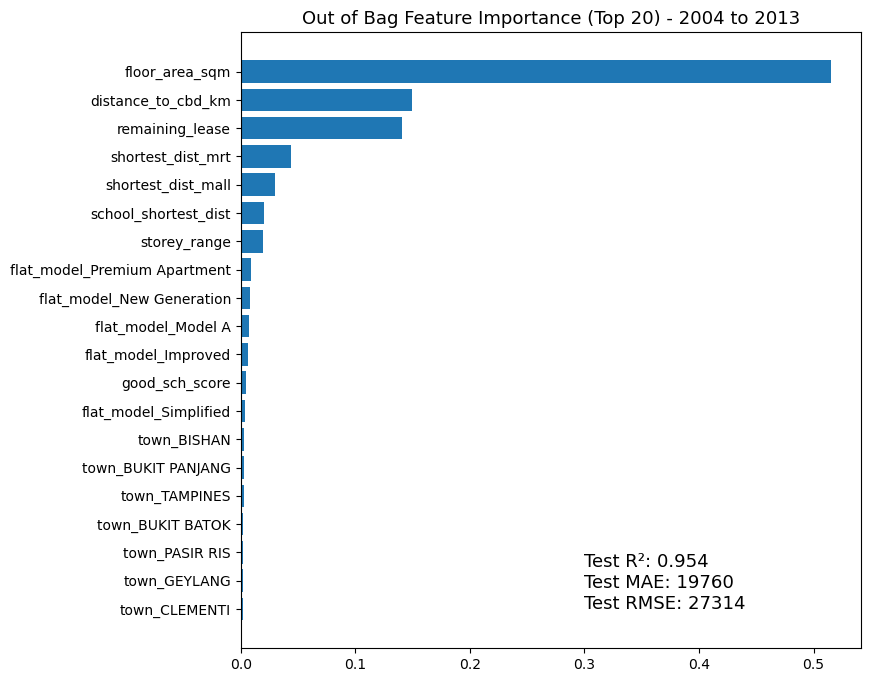

<Figure size 640x480 with 0 Axes>

In [75]:
plt.figure(figsize=(8,8))
oob_importance_graph = oob_importance.tail(20)
plt.barh(oob_importance_graph['Features'], oob_importance_graph['Coeff'])
plt.title('Out of Bag Feature Importance (Top 20) - 2004 to 2013', size = 13)
plt.annotate(('Test R\u00b2: ' + str(round(oob_r2,3)) + '\nTest MAE: ' + str(round(oob_mae))+
             '\nTest RMSE: ' + str(round(oob_rmse))),
             xy=(0.3,0), fontsize = 13)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


plt.show()

#### XGBoost

In [46]:
xgb = XGBRegressor()
xgb_r2, xgb_mae, xgb_rmse = model_performance(xgb, X_train, X_test, y_train, y_test)

R^2 score = 0.9023672272685007
MAE: 30080.102392610246
RMSE 39669.287356260655


In [47]:
xgb_importance = pd.DataFrame(list(zip(X_train.columns, xgb.feature_importances_)), columns =['Features', 'Coeff'])
xgb_importance = xgb_importance.sort_values(by = 'Coeff', ascending = True)
xgb_importance

,Features,Coeff
21,town_KALLANG/WHAMPOA,0.004901
14,town_CENTRAL AREA,0.005016
5,school_shortest_dist,0.005613
36,flat_model_Model A2,0.006138
6,good_sch_score,0.008353
34,flat_model_Maisonette,0.008857
4,shortest_dist_mall,0.009241
8,town_BEDOK,0.009683
26,town_SEMBAWANG,0.010629
30,town_TOA PAYOH,0.010730


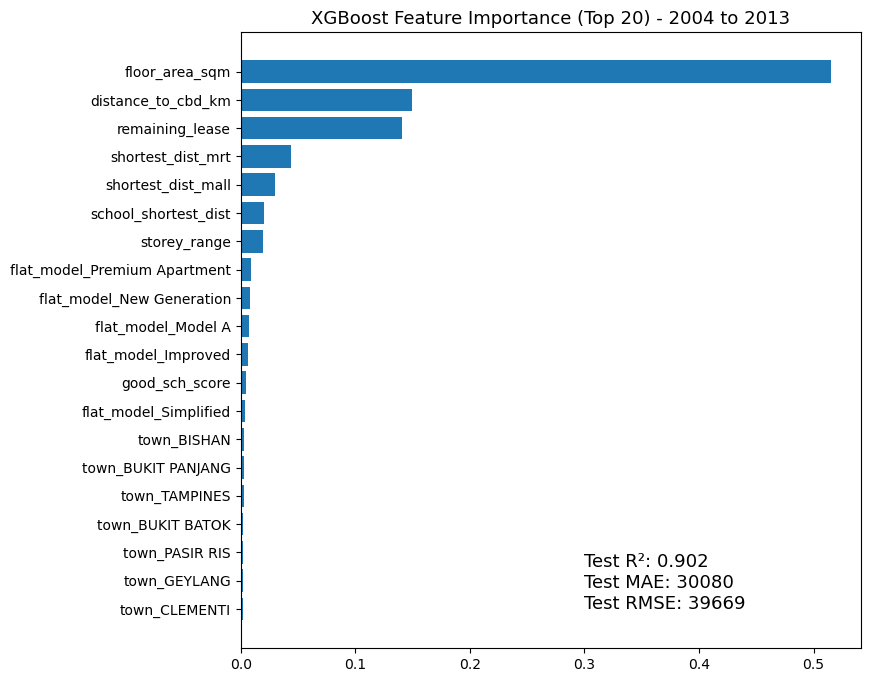

<Figure size 640x480 with 0 Axes>

In [79]:
plt.figure(figsize=(8,8))
oob_importance_graph = oob_importance.tail(20)
plt.barh(oob_importance_graph['Features'], oob_importance_graph['Coeff'])
plt.title('XGBoost Feature Importance (Top 20) - 2004 to 2013', size = 13)
plt.annotate(('Test R\u00b2: ' + str(round(xgb_r2,3)) + '\nTest MAE: ' + str(round(xgb_mae))+
             '\nTest RMSE: ' + str(round(xgb_rmse))),
             xy=(0.3,0), fontsize = 13)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


plt.show()

### Graph

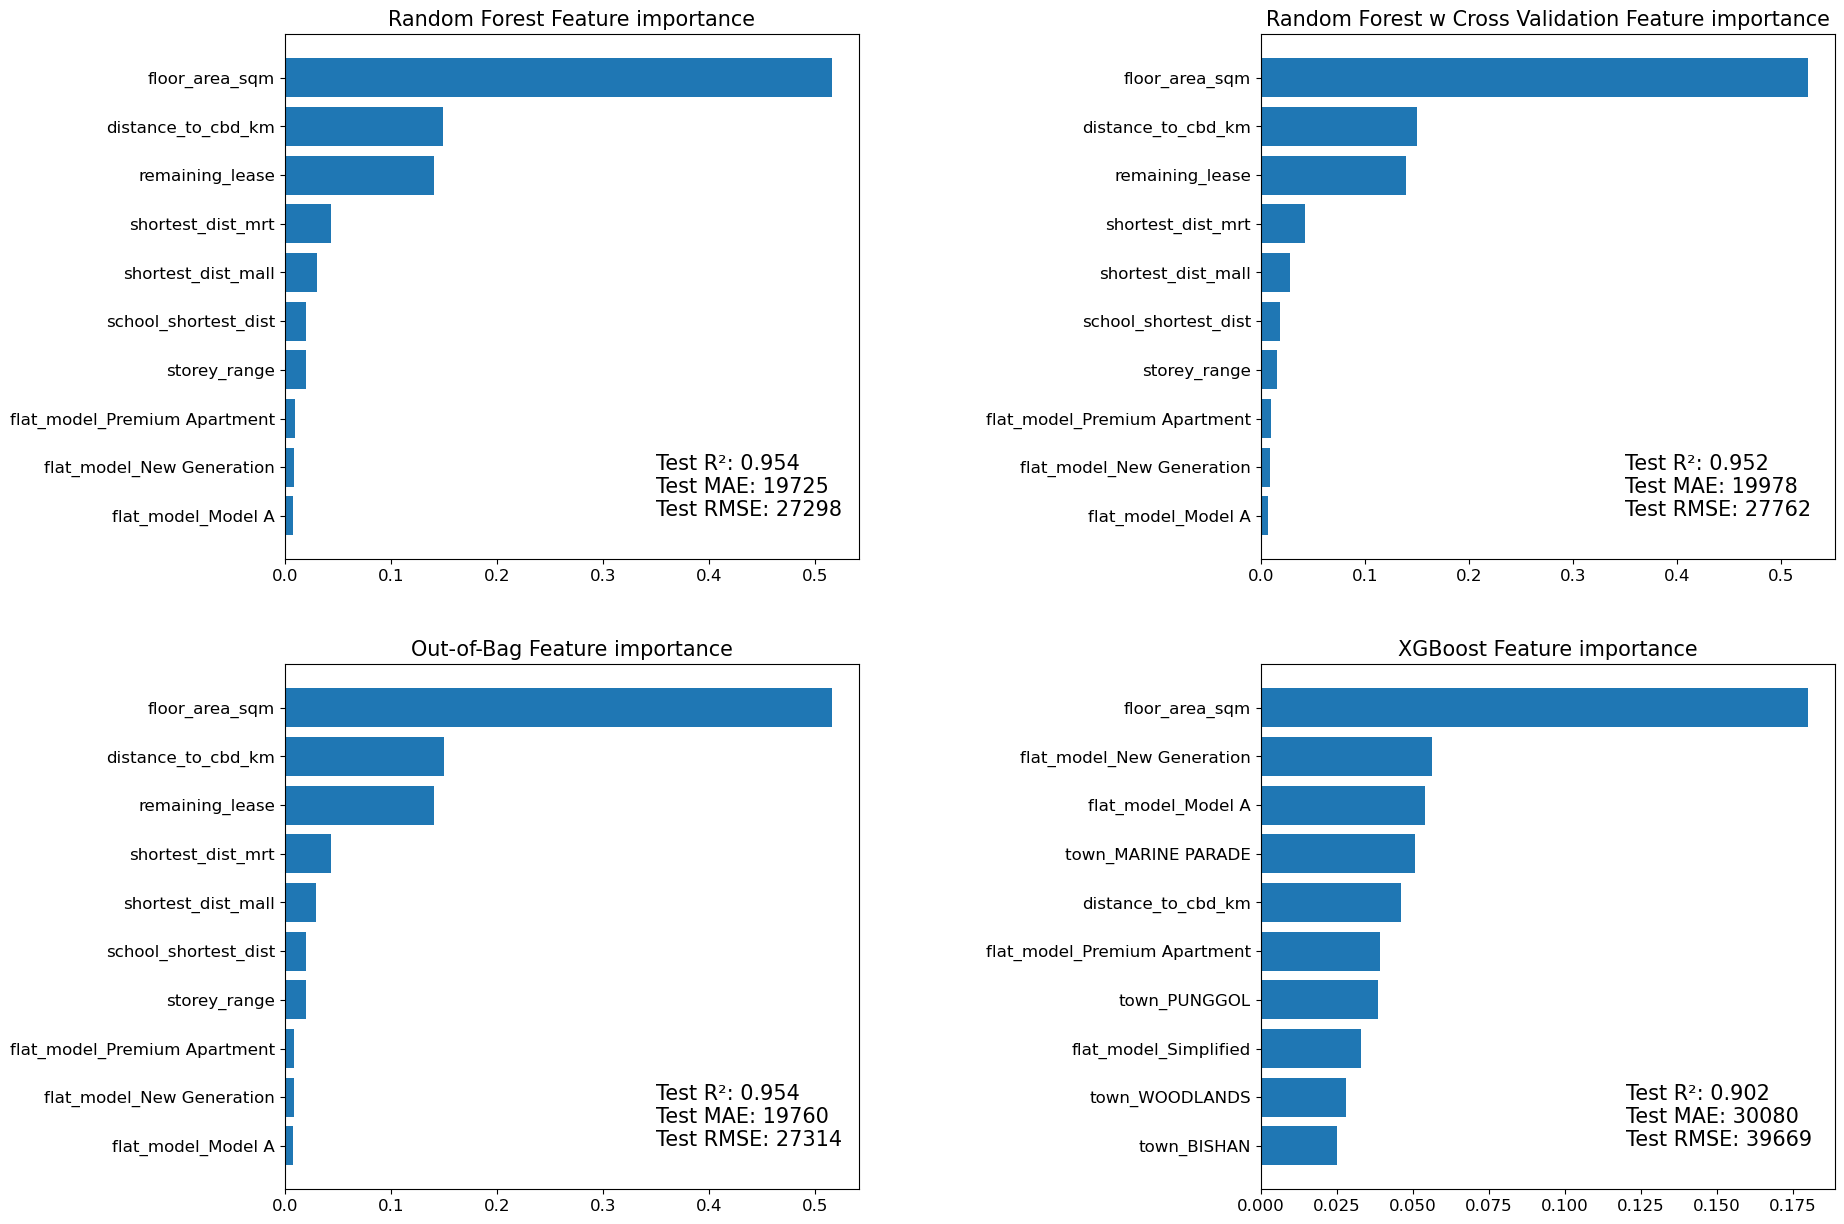

<Figure size 640x480 with 0 Axes>

In [51]:
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
rf_importance_graph = rf_importance.tail(10)
plt.barh(rf_importance_graph['Features'], rf_importance_graph['Coeff'])
plt.title('Random Forest Feature importance', size = 15)
plt.annotate(('Test R\u00b2: ' + str(round(rf_r2,3)) + '\nTest MAE: ' + str(round(rf_mae))+
             '\nTest RMSE: ' + str(round(rf_rmse))),
             xy=(0.35,0), fontsize = 15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2, 2, 2)
rf_random_importance_graph = rf_random_importance.tail(10)
plt.barh(rf_random_importance_graph['Features'], rf_random_importance_graph['Coeff'])
plt.title('Random Forest w Cross Validation Feature importance', size = 15)
plt.annotate(('Test R\u00b2: ' + str(round(rf_random_r2,3)) + '\nTest MAE: ' + str(round(rf_random_mae))+
             '\nTest RMSE: ' + str(round(rf_random_rmse))),
             xy=(0.35,0), fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.subplot(2, 2, 3)
oob_importance_graph = oob_importance.tail(10)
plt.barh(oob_importance_graph['Features'], oob_importance_graph['Coeff'])
plt.title('Out-of-Bag Feature importance', size = 15)
plt.annotate(('Test R\u00b2: ' + str(round(oob_r2,3)) + '\nTest MAE: ' + str(round(oob_mae))+
             '\nTest RMSE: ' + str(round(oob_rmse))),
             xy=(0.35,0), fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2, 2, 4)
xgb_importance_graph = xgb_importance.tail(10)
plt.barh(xgb_importance_graph['Features'], xgb_importance_graph['Coeff'])
plt.title('XGBoost Feature importance', size = 15)
plt.annotate(('Test R\u00b2: ' + str(round(xgb_r2,3)) + '\nTest MAE: ' + str(round(xgb_mae))+
             '\nTest RMSE: ' + str(round(xgb_rmse))),
             xy=(0.12,0), fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.7)

plt.show()

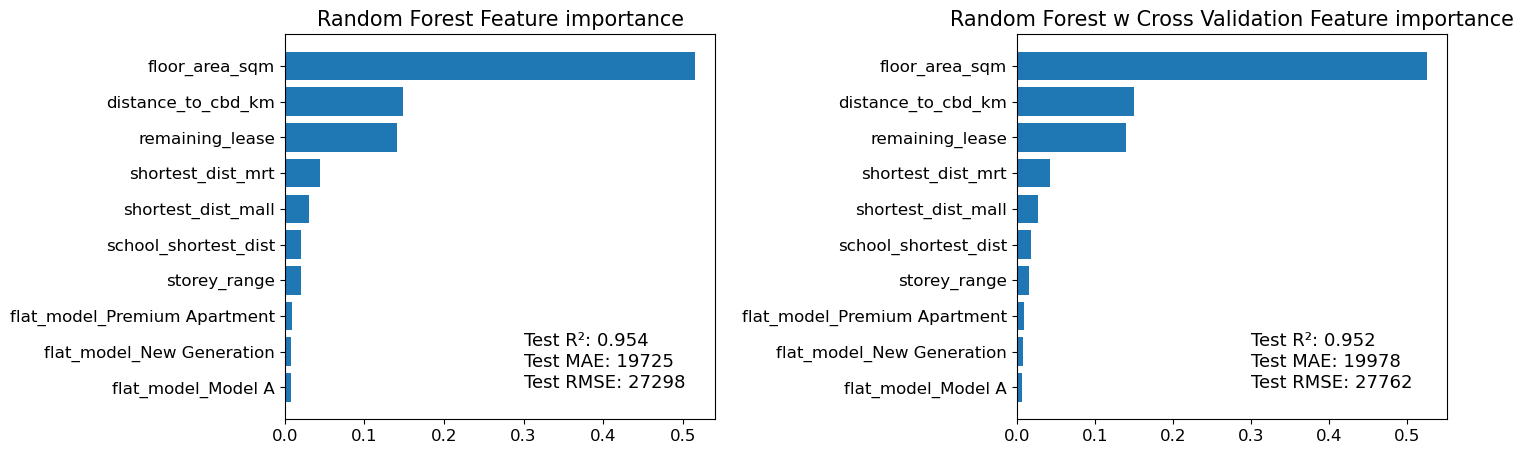

<Figure size 640x480 with 0 Axes>

In [55]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
rf_importance_graph = rf_importance.tail(10)
plt.barh(rf_importance_graph['Features'], rf_importance_graph['Coeff'])
plt.title('Random Forest Feature importance', size = 15)
plt.annotate(('Test R\u00b2: ' + str(round(rf_r2,3)) + '\nTest MAE: ' + str(round(rf_mae))+
             '\nTest RMSE: ' + str(round(rf_rmse))),
             xy=(0.3,0), fontsize = 13)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1, 2, 2)
rf_random_importance_graph = rf_random_importance.tail(10)
plt.barh(rf_random_importance_graph['Features'], rf_random_importance_graph['Coeff'])
plt.title('Random Forest w Cross Validation Feature importance', size = 15)
plt.annotate(('Test R\u00b2: ' + str(round(rf_random_r2,3)) + '\nTest MAE: ' + str(round(rf_random_mae))+
             '\nTest RMSE: ' + str(round(rf_random_rmse))),
             xy=(0.3,0), fontsize = 13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.subplots_adjust(wspace=0.7)

plt.show()

## Other Analysis

#### swap good_sch_score with good_sch_score_SAP_GEP

In [80]:
dropped_features_2 = ['mrt_count_within_1km','mall_count_within_1km',
                    'matured','good_sch_count_within_1km','flat_type','good_sch_score',
                    'year']

df_2 = data.drop(columns = dropped_features_2)

# Split target variable from dataset
y_2= df_2['adjusted_price']
X_2 = df_2.drop(columns='adjusted_price')

X2_train,X2_test,y2_train,y2_test=train_test_split(X_2,y_2,test_size=0.2,random_state=100)

# Scale dataset
continuous_features = ['floor_area_sqm', 'remaining_lease','shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist', 'distance_to_cbd_km']

scaler = StandardScaler()
X2_train_continuous = X2_train[continuous_features]
X2_train_continuous = scaler.fit_transform(X2_train_continuous)

X2_test_continuous = X2_test[continuous_features]
X2_test_continuous = scaler.transform(X2_test_continuous)

# Replace original continuous features with scaled ones in X

X2_train[continuous_features] = X2_train_continuous
X2_test[continuous_features] = X2_test_continuous

In [81]:
lr2 = LinearRegression()
lin_reg_2_r2, lin_reg_2_mae, lin_reg_2_rmse = model_performance(lr2, X2_train, X2_test, y2_train, y2_test)

R^2 score = 0.6200114196950732
MAE: 63908.03345181111
RMSE 78260.36327469177


In [82]:
lr_2_importance = pd.DataFrame(list(zip(lr2.feature_names_in_, lr2.coef_)), columns =['Features', 'Coeff'])
lr_2_importance = lr_2_importance.sort_values(by = 'Coeff', ascending = True)
lr_2_importance

,Features,Coeff
15,town_CHOA CHU KANG,-79073.276926
31,town_WOODLANDS,-74125.949549
32,town_YISHUN,-52823.180588
26,town_SEMBAWANG,-49706.310054
20,town_JURONG WEST,-47956.519456
40,flat_model_Standard,-43096.720484
18,town_HOUGANG,-42016.285120
23,town_PASIR RIS,-33025.290085
10,town_BUKIT BATOK,-27955.348884
19,town_JURONG EAST,-27297.860160


In [83]:
X2_constant = sm.add_constant(X2_train)
lr_ols = sm.OLS(y2_train,X2_constant).fit()
print(lr_ols.summary())

                            OLS Regression Results                            
Dep. Variable:         adjusted_price   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     8481.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:05:35   Log-Likelihood:            -2.6660e+06
No. Observations:              210047   AIC:                         5.332e+06
Df Residuals:                  210005   BIC:                         5.333e+06
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [84]:
lr_2_importance['feature_importance'] = np.abs(lr_2_importance['Coeff'])
lr_2_importance = lr_2_importance.sort_values('feature_importance').reset_index(drop= True)
lr_2_importance['color'] = lr_2_importance['Coeff'].apply(lambda x: '#66ff8c' if x>0 else '#ff8c66')
lr_2_importance

,Features,Coeff,feature_importance,color
0,good_sch_score_sap_gep,-1246.073841,1246.073841,#ff8c66
1,school_shortest_dist,1337.954964,1337.954964,#66ff8c
2,flat_model_Model A,1531.250674,1531.250674,#66ff8c
3,town_BUKIT PANJANG,-2220.086574,2220.086574,#ff8c66
4,flat_model_Simplified,2610.930094,2610.930094,#66ff8c
5,town_SERANGOON,-5560.267078,5560.267078,#ff8c66
6,town_SENGKANG,-6417.571299,6417.571299,#ff8c66
7,storey_range,7706.957474,7706.957474,#66ff8c
8,distance_to_cbd_km,-9378.316853,9378.316853,#ff8c66
9,town_BEDOK,9701.146729,9701.146729,#66ff8c


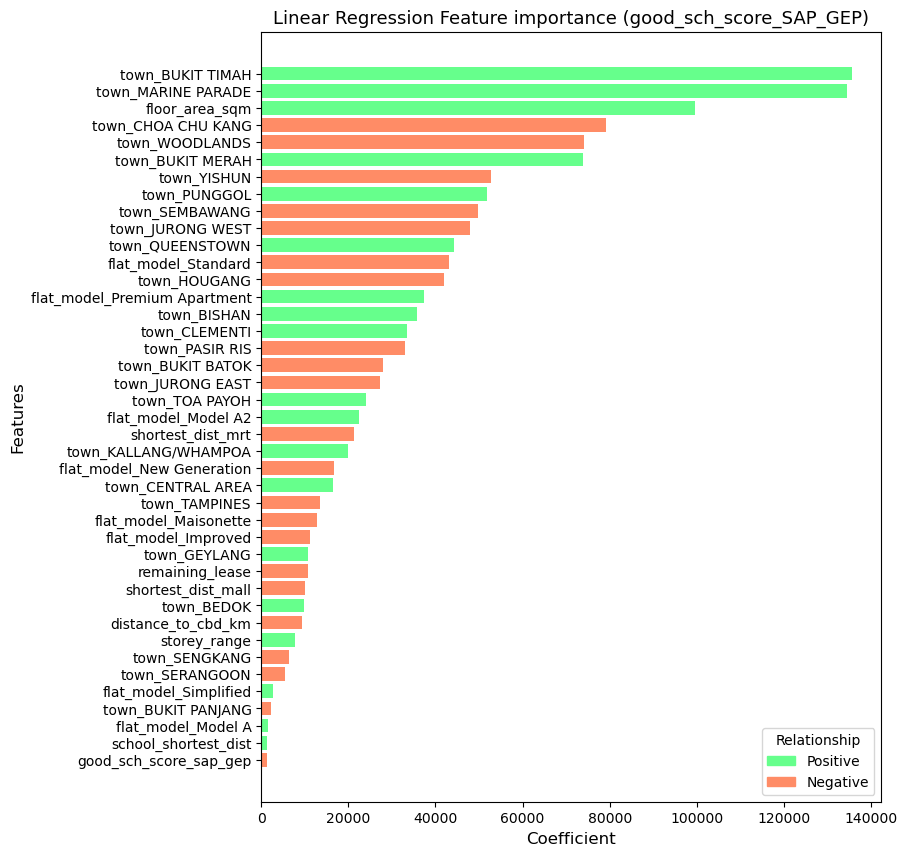

<Figure size 640x480 with 0 Axes>

In [89]:
plt.figure(figsize=(8,10))
plt.barh(lr_2_importance['Features'], lr_2_importance['feature_importance'],
         color=lr_2_importance['color'])


colors = {'Positive':'#66ff8c', 'Negative':'#ff8c66'}       
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, title='Relationship',loc='lower right', fontsize ='10')

plt.title('Linear Regression Feature importance (good_sch_score_SAP_GEP)', size = 13)
plt.ylabel('Features', size = 12)
plt.xlabel('Coefficient', size = 12)

plt.show()

In [92]:
rf_2 = RandomForestRegressor()
rf_2_r2, rf_2_mae, rf_2_rmse = model_performance(rf_2, X2_train, X2_test, y2_train, y2_test)

rf_2_importance = pd.DataFrame(list(zip(rf_2.feature_names_in_, rf_2.feature_importances_)), columns =['Features', 'Coeff'])
rf_2_importance = rf_2_importance.sort_values(by = 'Coeff', ascending = True)
rf_2_importance

R^2 score = 0.9538064699164837
MAE: 19748.748161866384
RMSE 27286.457909448345


,Features,Coeff
14,town_CENTRAL AREA,0.000389
36,flat_model_Model A2,0.000503
34,flat_model_Maisonette,0.000708
21,town_KALLANG/WHAMPOA,0.000720
26,town_SEMBAWANG,0.000764
15,town_CHOA CHU KANG,0.000831
24,town_PUNGGOL,0.000848
30,town_TOA PAYOH,0.000957
11,town_BUKIT MERAH,0.001089
13,town_BUKIT TIMAH,0.001127


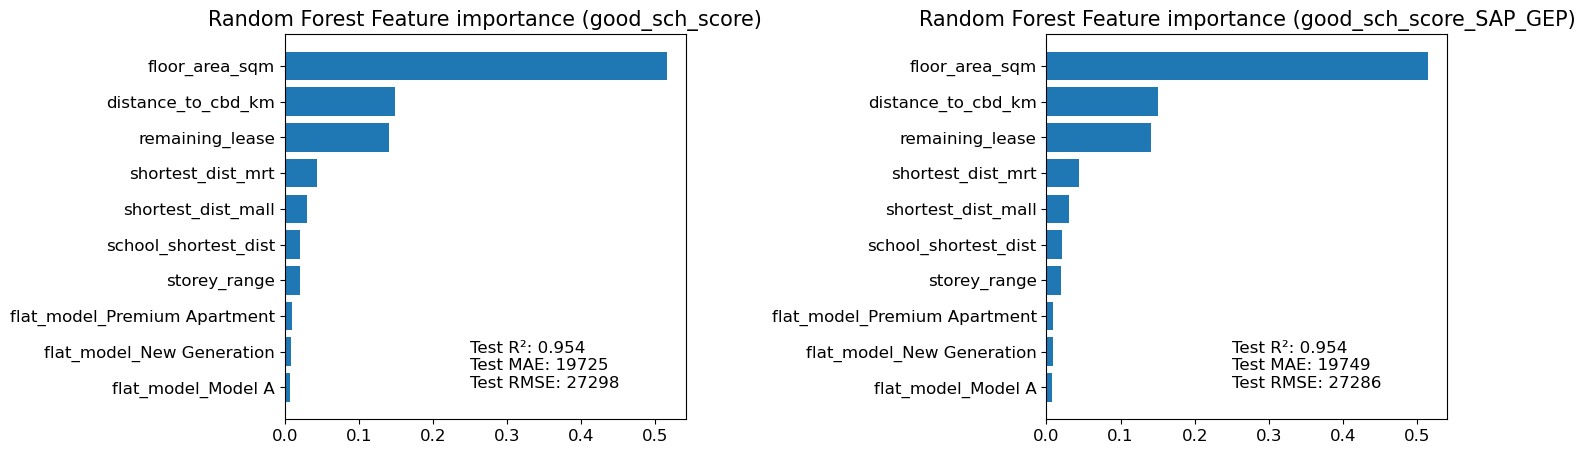

In [101]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
rf_importance_graph = rf_importance.tail(10)
plt.barh(rf_importance_graph['Features'], rf_importance_graph['Coeff'])
plt.title('Random Forest Feature importance (good_sch_score)', size = 15)
plt.annotate(('Test R\u00b2: ' + str(round(rf_r2,3)) + '\nTest MAE: ' + str(round(rf_mae))+
             '\nTest RMSE: ' + str(round(rf_rmse))),
             xy=(0.25,0), fontsize = 12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1, 2, 2)
rf_2_importance_graph = rf_2_importance.tail(10)
plt.barh(rf_2_importance_graph['Features'], rf_2_importance_graph['Coeff'])
plt.title('Random Forest Feature importance (good_sch_score_SAP_GEP)', size = 15)
plt.annotate(('Test R\u00b2: ' + str(round(rf_2_r2,3)) + '\nTest MAE: ' + str(round(rf_2_mae))+
             '\nTest RMSE: ' + str(round(rf_2_rmse))),
             xy=(0.25,0), fontsize = 12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.subplots_adjust(wspace=0.9)

plt.show()

#### What if we remove floor_area_sqm, distance_to_cbd_km, and remaining_lease from the feature list?

In [103]:
dropped_features_2 = ['mrt_count_within_1km','mall_count_within_1km',
                    'matured','good_sch_count_within_1km','floor_area_sqm','flat_type',
                    'good_sch_score', 'year', 'distance_to_cbd_km', 'remaining_lease']

df_2 = data.drop(columns = dropped_features_2)

# Split target variable from dataset
y_2= df_2['adjusted_price']
X_2 = df_2.drop(columns='adjusted_price')

X2_train,X2_test,y2_train,y2_test=train_test_split(X_2,y_2,test_size=0.2,random_state=100)

# Scale dataset
continuous_features = ['shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist']

scaler = StandardScaler()
X2_train_continuous = X2_train[continuous_features]
X2_train_continuous = scaler.fit_transform(X2_train_continuous)

X2_test_continuous = X2_test[continuous_features]
X2_test_continuous = scaler.transform(X2_test_continuous)

# Replace original continuous features with scaled ones in X

X2_train[continuous_features] = X2_train_continuous
X2_test[continuous_features] = X2_test_continuous

In [104]:
lr3 = LinearRegression()
lin_reg_3_r2, lin_reg_3_mae, lin_reg_3_rmse = model_performance(lr3, X2_train, X2_test, y2_train, y2_test)

lr3_importance = pd.DataFrame(list(zip(lr3.feature_names_in_, lr3.coef_)), columns =['Features', 'Coeff'])
lr3_importance.sort_values(by = 'Coeff', ascending = False)

R^2 score = 0.37367164067311054
MAE: 79459.35575407917
RMSE 100474.90984722713


,Features,Coeff
10,town_BUKIT TIMAH,149016.868292
19,town_MARINE PARADE,104772.295476
6,town_BISHAN,72251.051557
8,town_BUKIT MERAH,53250.367497
21,town_PUNGGOL,50083.778334
13,town_CLEMENTI,33620.830142
31,flat_model_Maisonette,14406.523140
20,town_PASIR RIS,11516.300329
0,storey_range,9733.798324
25,town_SERANGOON,8145.861553


In [105]:
lr3_importance['feature_importance'] = np.abs(lr3_importance['Coeff'])
lr3_importance = lr3_importance.sort_values('feature_importance').reset_index(drop= True)
lr3_importance['color'] = lr3_importance['Coeff'].apply(lambda x: '#66ff8c' if x>0 else '#ff8c66')
lr3_importance

,Features,Coeff,feature_importance,color
0,school_shortest_dist,-941.039052,941.039052,#ff8c66
1,good_sch_score_sap_gep,1811.451083,1811.451083,#66ff8c
2,town_TAMPINES,2353.670820,2353.670820,#66ff8c
3,town_BUKIT PANJANG,3175.817744,3175.817744,#66ff8c
4,town_BEDOK,3413.768421,3413.768421,#66ff8c
5,town_SENGKANG,-5376.154652,5376.154652,#ff8c66
6,town_SERANGOON,8145.861553,8145.861553,#66ff8c
7,shortest_dist_mall,-9184.702667,9184.702667,#ff8c66
8,storey_range,9733.798324,9733.798324,#66ff8c
9,town_PASIR RIS,11516.300329,11516.300329,#66ff8c


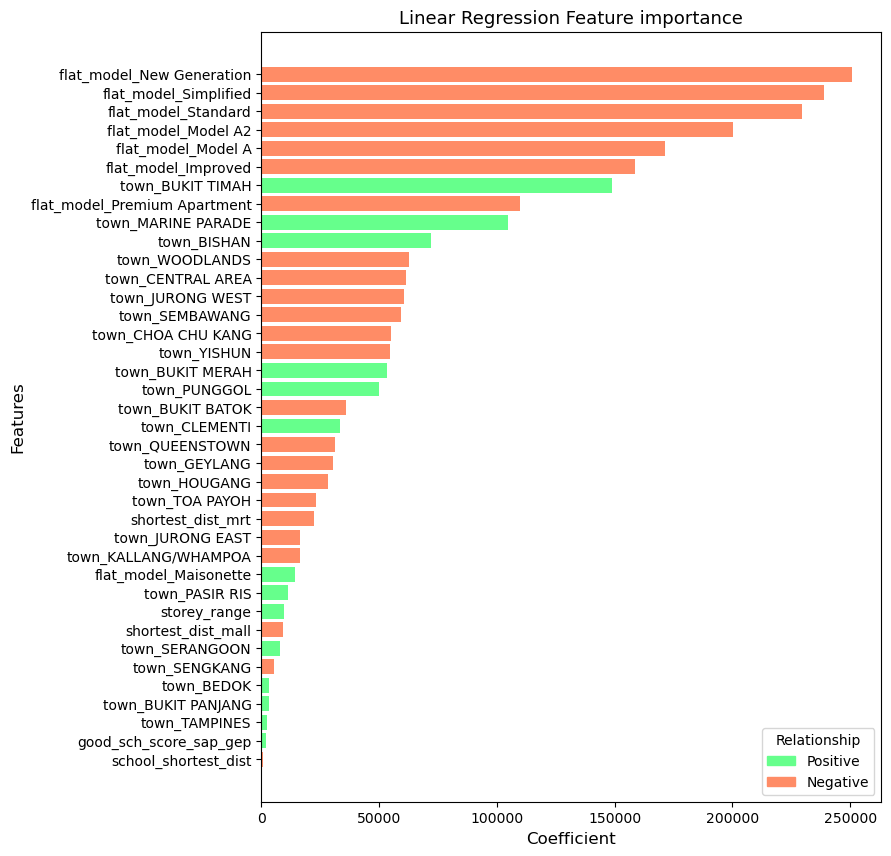

In [106]:
plt.figure(figsize=(8,10))
plt.barh(lr3_importance['Features'], lr3_importance['feature_importance'],
         color=lr3_importance['color'])


colors = {'Positive':'#66ff8c', 'Negative':'#ff8c66'}       
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, title='Relationship',loc='lower right', fontsize ='10')

plt.title('Linear Regression Feature importance', size = 13)
plt.ylabel('Features', size = 12)
plt.xlabel('Coefficient', size = 12)

plt.show()

In [111]:
rf_3 = RandomForestRegressor()
rf_3_r2, rf_3_mae, rf_3_rmse = model_performance(rf_3, X2_train, X2_test, y2_train, y2_test)

rf_3_importance = pd.DataFrame(list(zip(rf_3.feature_names_in_, rf_3.feature_importances_)), columns =['Features', 'Coeff'])
rf_3_importance = rf_3_importance.sort_values(by = 'Coeff', ascending = True)
rf_3_importance

R^2 score = 0.6526316034349101
MAE: 60245.894737208786
RMSE 74825.86377614675


,Features,Coeff
9,town_BUKIT PANJANG,0.001278
23,town_SEMBAWANG,0.001794
11,town_CENTRAL AREA,0.002521
10,town_BUKIT TIMAH,0.002562
16,town_JURONG EAST,0.002624
21,town_PUNGGOL,0.003175
12,town_CHOA CHU KANG,0.004042
20,town_PASIR RIS,0.004057
25,town_SERANGOON,0.004172
15,town_HOUGANG,0.004736


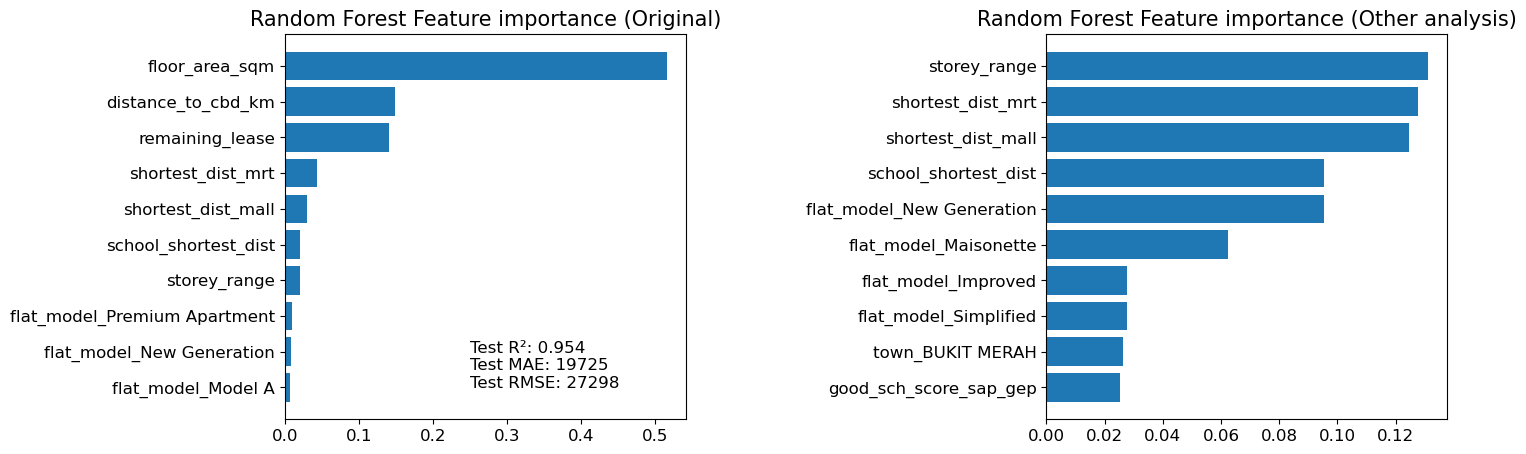

In [112]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
rf_importance_graph = rf_importance.tail(10)
plt.barh(rf_importance_graph['Features'], rf_importance_graph['Coeff'])
plt.title('Random Forest Feature importance (Original)', size = 15)
plt.annotate(('Test R\u00b2: ' + str(round(rf_r2,3)) + '\nTest MAE: ' + str(round(rf_mae))+
             '\nTest RMSE: ' + str(round(rf_rmse))),
             xy=(0.25,0), fontsize = 12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1, 2, 2)
rf_3_importance_graph = rf_3_importance.tail(10)
plt.barh(rf_3_importance_graph['Features'], rf_3_importance_graph['Coeff'])
plt.title('Random Forest Feature importance (Other analysis)', size = 15)
plt.annotate(('Test R\u00b2: ' + str(round(rf_3_r2,3)) + '\nTest MAE: ' + str(round(rf_3_mae))+
             '\nTest RMSE: ' + str(round(rf_3_rmse))),
             xy=(0.25,0), fontsize = 12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.subplots_adjust(wspace=0.9)

plt.show()